In [1]:
import os
import gc
import math

# numpy
import numpy as np
import numpy.ma as ma

from jax import vmap, grad, jit, random
from jax.config import config
# from jax.experimental import optimizers
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

config.update("jax_enable_x64", True)

# from skimage.restoration import estimate_sigma
from skimage.transform import resize

### CRPS
import properscoring as ps

### SSIM and PSNR
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import filters

# plotting
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from cartopy import config
import cartopy.crs as ccrs

# netCDF
import netCDF4 as nc

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import pickle

In [2]:
xhist_tas = pickle.load(open('../data/saved/xhist_tas.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/saved/xrcp_tas.pkl', 'rb'))

xhist_pr = pickle.load(open('../data/saved/xhist_pr.pkl', 'rb'))
xrcp_pr = pickle.load(open('../data/saved/xrcp_pr.pkl', 'rb'))

In [3]:
nval = 72
nmod = len(xhist_tas)

In [4]:
sgpr_tas = [np.load(f'tas_predictions/sgpr_tas_{m}.npz.npy') for m in trange(nmod)]
xreg_tas = [np.load(f'tas_predictions/xreg_tas_{m}.npz.npy') for m in trange(nmod)]
xbar_tas = [np.load(f'tas_predictions/xbar_tas_{m}.npz.npy') for m in trange(nmod)]
xwea_tas = [np.load(f'tas_predictions/xwea_tas_{m}.npz.npy') for m in trange(nmod)]
gpse_tas = [np.load(f'tas_predictions/gpr_se_tas_{m}.npz.npy') for m in trange(nmod)]
gpex_tas = [np.load(f'tas_predictions/gpr_exp_tas_{m}.npz.npy') for m in trange(nmod)]
dcnn_tas = [np.load(f'tas_predictions/cnn_tas_{m}.npz.npy') for m in trange(nmod)]
delt_tas = [np.load(f'tas_predictions/del_tas_{m}.npz.npy') for m in trange(nmod)]

sgpr_pr = [np.load(f'pr_predictions/sgpr_pr_{m}.npz.npy') for m in trange(nmod)]
xreg_pr = [np.load(f'pr_predictions/xreg_pr_{m}.npz.npy') for m in trange(nmod)]
xbar_pr = [np.load(f'pr_predictions/xbar_pr_{m}.npz.npy') for m in trange(nmod)]
xwea_pr = [np.load(f'pr_predictions/xwea_pr_{m}.npz.npy') for m in trange(nmod)]
gpse_pr = [np.load(f'pr_predictions/gpr_se_pr_{m}.npz.npy') for m in trange(nmod)]
gpex_pr = [np.load(f'pr_predictions/gpr_exp_pr_{m}.npz.npy') for m in trange(nmod)]
dcnn_pr = [np.load(f'pr_predictions/cnn_pr_{m}.npz.npy') for m in trange(nmod)]
delt_pr = [np.load(f'pr_predictions/del_pr_{m}.npz.npy') for m in trange(nmod)]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [89]:
(0.97 - 0.62) / 0.97

0.36082474226804123

In [6]:
ntest = sgpr_tas[0].shape[0] + nval

In [7]:
months = 12 * 10
decades = int((ntest-nval)/(months))

In [8]:
sgpr_mse_tas = np.zeros((decades, nmod))
xreg_mse_tas = np.zeros((decades, nmod))
xwea_mse_tas = np.zeros((decades, nmod))
xbar_mse_tas = np.zeros((decades, nmod))
gpse_mse_tas = np.zeros((decades, nmod))
gpex_mse_tas = np.zeros((decades, nmod))
dcnn_mse_tas = np.zeros((decades, nmod))
delt_mse_tas = np.zeros((decades, nmod))

sgpr_mse_pr = np.zeros((decades, nmod))
xreg_mse_pr = np.zeros((decades, nmod))
xwea_mse_pr = np.zeros((decades, nmod))
xbar_mse_pr = np.zeros((decades, nmod))
gpse_mse_pr = np.zeros((decades, nmod))
gpex_mse_pr = np.zeros((decades, nmod))
dcnn_mse_pr = np.zeros((decades, nmod))
delt_mse_pr = np.zeros((decades, nmod))

sgpr_ssim_tas = np.zeros((decades, nmod))
xreg_ssim_tas = np.zeros((decades, nmod))
xwea_ssim_tas = np.zeros((decades, nmod))
xbar_ssim_tas = np.zeros((decades, nmod))
gpse_ssim_tas = np.zeros((decades, nmod))
gpex_ssim_tas = np.zeros((decades, nmod))
dcnn_ssim_tas = np.zeros((decades, nmod))
delt_ssim_tas = np.zeros((decades, nmod))

sgpr_ssim_pr = np.zeros((decades, nmod))
xreg_ssim_pr = np.zeros((decades, nmod))
xwea_ssim_pr = np.zeros((decades, nmod))
xbar_ssim_pr = np.zeros((decades, nmod))
gpse_ssim_pr = np.zeros((decades, nmod))
gpex_ssim_pr = np.zeros((decades, nmod))
dcnn_ssim_pr = np.zeros((decades, nmod))
delt_ssim_pr = np.zeros((decades, nmod))

for m1 in trange(nmod):
    ytest_tas = np.array(xrcp_tas[m1])[nval:ntest]
    ytest_pr = np.array(xrcp_pr[m1])[nval:ntest]
    
    nlat = ytest_tas.shape[1]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
    
    for d in range(decades):
        
        ytest_dec = ytest_tas[(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        
        sgpr_dec = sgpr_tas[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]


        ytest_dec = ytest_pr[(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]

        sgpr_dec = sgpr_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        xreg_dec = xreg_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        xwea_dec = xwea_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        xbar_dec = xbar_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        gpse_dec = gpse_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        gpex_dec = gpex_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        dcnn_dec = dcnn_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        delt_dec = delt_pr[m1][(months*d):(months*(d+1))].astype('float32') * scale[None,:,None]
        
        sgpr_mse_pr[d, m1] = np.mean((sgpr_dec - ytest_dec)**2)
        xreg_mse_pr[d, m1] = np.mean((xreg_dec - ytest_dec)**2)
        xwea_mse_pr[d, m1] = np.mean((xwea_dec - ytest_dec)**2)
        xbar_mse_pr[d, m1] = np.mean((xbar_dec - ytest_dec)**2)
        gpse_mse_pr[d, m1] = np.mean((gpse_dec - ytest_dec)**2)
        gpex_mse_pr[d, m1] = np.mean((gpex_dec - ytest_dec)**2)
        dcnn_mse_pr[d, m1] = np.mean((dcnn_dec - ytest_dec)**2)
        delt_mse_pr[d, m1] = np.mean((delt_dec - ytest_dec)**2)
        
        sgpr_ssim_pr[d, m1] = ssim(sgpr_dec, ytest_dec)
        xreg_ssim_pr[d, m1] = ssim(xreg_dec, ytest_dec)
        xwea_ssim_pr[d, m1] = ssim(xwea_dec, ytest_dec)
        xbar_ssim_pr[d, m1] = ssim(xbar_dec, ytest_dec)
        gpse_ssim_pr[d, m1] = ssim(gpse_dec, ytest_dec)
        gpex_ssim_pr[d, m1] = ssim(gpex_dec, ytest_dec)
        dcnn_ssim_pr[d, m1] = ssim(dcnn_dec, ytest_dec)
        delt_ssim_pr[d, m1] = ssim(delt_dec, ytest_dec)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

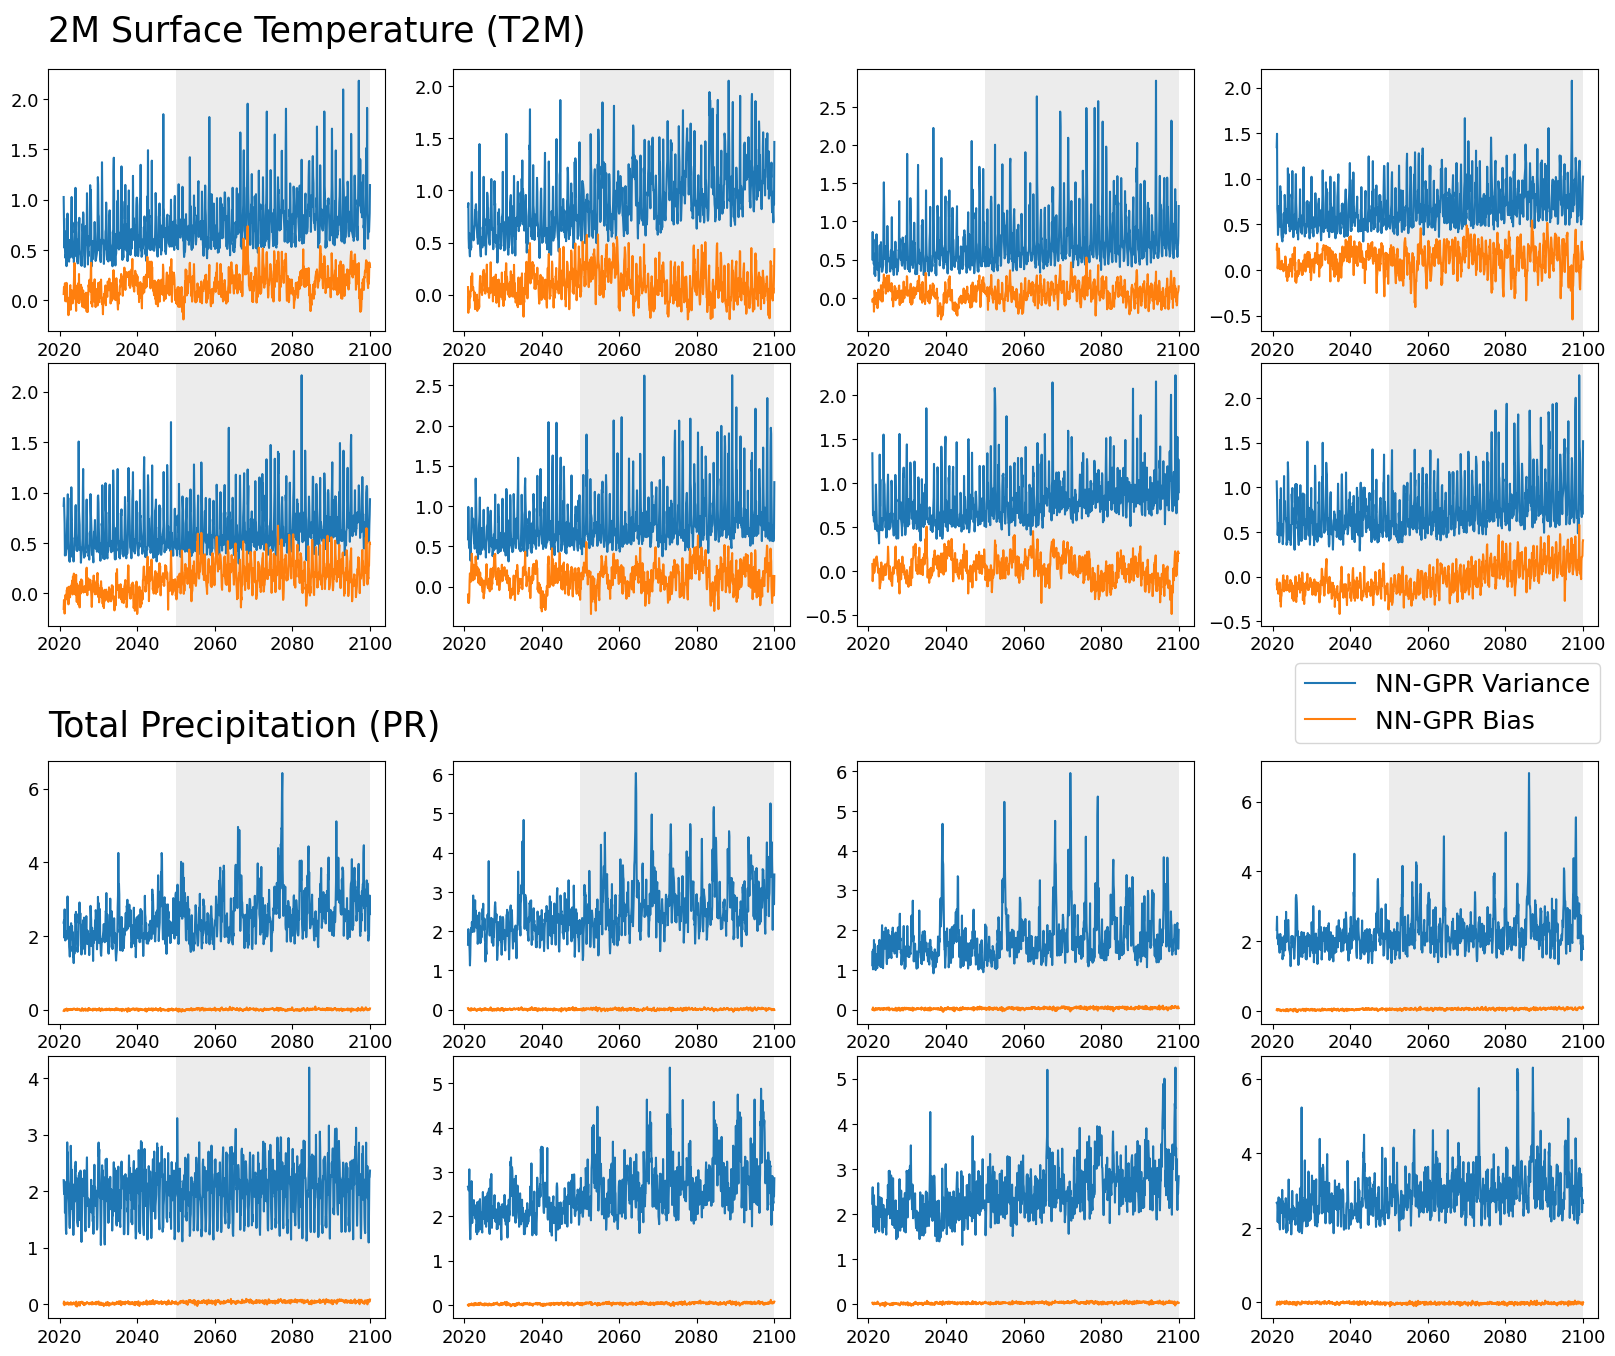

In [8]:
fig = plt.figure(constrained_layout = False, figsize = (20, 17))
gs = GridSpec(7, 4, height_ratios=[0.105, 1, 1, 0.1, 0.05, 1, 1], figure = fig)

plt.rc('ytick', labelsize = 13)
plt.rc('xtick', labelsize = 13)

ax = plt.subplot(gs[0, 0])
ax.axis('off')
ax.text(0.0, 0.2, '2M Surface Temperature (T2M)', va='center', fontsize=25)

ntest = sgpr_tas[0].shape[0] + nval
s = np.linspace(2021, 2100, ntest-nval)
for k in trange(4, 12):
    ax = plt.subplot(gs[1 + int(k > 7), k % 4])
    
    gphat = sgpr_tas[k]
    nobs, nlat, nlon = gphat.shape
    
    ytest = xrcp_tas[k][nval:].reshape((-1, nlat, nlon))
    
    nlat = ytest.shape[1]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
    
    gphat = gphat * scale[None,:,None]
    ytest = ytest * scale[None,:,None]

    bias = np.mean(gphat - ytest, axis = (1, 2))
    vari = np.var(gphat - ytest, axis = (1, 2))
    
    ax.plot(s, vari, label='NN-GPR Variance')
    ax.plot(s, bias, label='NN-GPR Bias')
    ax.axvspan(2050, 2100, facecolor='grey', alpha=0.15)
    
    
ax = plt.subplot(gs[4, 0])
ax.axis('off')
ax.text(0.0, 0.2, 'Total Precipitation (PR)', va='center', fontsize=25)
ntest = sgpr_pr[0].shape[0] + nval
s = np.linspace(2021, 2100, ntest-nval)
for k in trange(4, 12):
    ax = plt.subplot(gs[5 + int(k > 7), k % 4])
    
    gphat = sgpr_pr[k]
    nobs, nlat, nlon = gphat.shape
    
    ytest = xrcp_pr[k][nval:].reshape((-1, nlat, nlon))
    
    nlat = ytest.shape[1]
    scale = np.cos(np.linspace(math.pi/2, -math.pi/2, nlat))
    
    gphat = gphat * scale[None,:,None]
    ytest = ytest * scale[None,:,None]

    bias = np.mean(gphat - ytest, axis = (1, 2))
    vari = np.var(gphat - ytest, axis = (1, 2))

    ax.plot(s, vari, label='NN-GPR Variance')
    ax.plot(s, bias, label='NN-GPR Bias')
    ax.axvspan(2050, 2100, facecolor='grey', alpha=0.15)
    
plt.legend(loc=(0.1, 2.19), fontsize = 18)